In [1]:
import numpy
from matplotlib import pyplot
from matplotlib import colors
% matplotlib inline

In [2]:
from collections.abc import Mapping

In [3]:
import os, sys
sys.path.append(os.path.split(os.getcwd())[0])

In [4]:
import utils.poly as poly
import utils.quadrature as quad

### A. Problem description

#### A-1. PDE

$$
\frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} = 0
$$

#### A-2. Initial condition

$$
u_{init} = e^{-40(x-0.5)^2}
$$

In [5]:
def u_init(x):
    """initial condition of u"""
    temp = x - 0.5
    return numpy.exp(-40 * temp * temp)

#### A-3. Exact solution

$$
u_{exact} = e^{\left[-40(x-0.5-t)^2\right]}
$$

#### A-4. Flux function

The PDE is already in conservative form.
And thus the flux of the conservation law in this problem is

$$
f(x) = f(u(x)) = u(x)
$$

In [6]:
def flux(u):
    """flux in PDE"""
    return u

#### A-5. Wave propagation speed, a

$$
a(x) = a(u) = \frac{df}{du} = 1
$$

### B. Distribution of solution points on single element

#### B-1. Equally distribution

Solution points are equally distributed on a single element but exclude the two end nodes.

In [7]:
def equalDistrib(N):
    """"""
    return numpy.linspace(-1., 1., N, endpoint=False) + 1. / N

#### B-2. Legendre-Lobatto
Solution points are the quadrature nodes of Gauss-Lobatto-Legendre quadrature.

In [8]:
def LegendreLobatto(N):
    """"""
    return quad.GaussLobattoJacobi(N).nodes

#### B-3. Gauss (or Legendre-Gauss)
Solution points are the quadrature nodes of Gauss-Legendre quadrature.

In [9]:
def LegendreGauss(N):
    """"""
    return quad.GaussJacobi(N).nodes

#### B-4. Chebyshev-Lobatto
Solution points are the quadrature nodes of Gauss-Lobatto-Chebyshev quadrature.

In [10]:
def ChebyshevLobatto(N):
    """"""
    return - numpy.cos(numpy.arange(N, dtype=numpy.float64) * numpy.pi / (N-1))

Finally, let's define a dictionary collecting these distribution functions for the purpose of later coding.

In [11]:
soln_point_distrib = {
    "equal": equalDistrib,
    "LegendreLobatto": LegendreLobatto,
    "LegendreGauss": LegendreGauss,
    "ChebyshevLobatto": ChebyshevLobatto
}

### C. Flux correction function ($g_{LB}$ and $g_{RB}$)

Though what we'll define mathematically are flux correction functions (i.e. $g_{LB}$ and $g_{RB}$), 
we only need the derivatives of these functions at solution points in numerical solvers, that is, $\frac{dg_{LB}}{d\xi}(\xi_k)$ and $\frac{dg_{RB}}{d\xi}(\xi_k)$, where $\xi_k,\ k=1,\dots,N$ are solution points on each element.
So the Python function defined below only return a `numpy.ndarray` of these derivatives.

$N$ in this section always represents the number of solution points on each element.

#### C-1. Discontinuous Galerkin, $g_{DG}$ (a.k.a. $g_1$)

$g_{DG}$ is defined as Radau polynomial (p.s. the roots of Radau polynomials are the quadrature nodes of Gauss-Radau-Legendre quadrature).

$$
\left\{
\begin{align*}
g_{DG,LB}(\xi) & = R_{R,N}(\xi) = (-1)^N\frac{1}{2}(L_N(\xi) - L_{N-1}(\xi)) \\
g_{DG,RB}(\xi) & = R_{L,N}(\xi) = \frac{1}{2}(L_N(\xi) + L_{N-1}(\xi)) \\
\end{align*}
\right.
$$

where the subscripts $LB$ and $RB$ denote whether the functions apply to left or right interface of each element; $R_{R,N}$ and $R_{L,N}$ are right- and left-Radau polynomial of order $N$; $L_N$ represents Legendre polynomial of order $N$.

In [12]:
def dgDG(xi, side):
    """flux correction scheme: discontinuous Galerkin, aka. g1
    
    This function returns the derivatives of g_{DG} at solution points
    
    Args:
        xi: numpy.ndarray, local coordinates of solution points
        side: string, either 'left' or 'right', indicating which bouyndary of 
              element will be corrected
    """
    
    # number of solution points, also the order of correction polynomial
    N = xi.size
    
    # dg/dx
    if side == 'left':
        dg = poly.Radau(N, end=1).derive()
    elif side == 'right':
        dg = poly.Radau(N, end=-1).derive()
    else:
        raise ValueError("illegal value for argument 'side'")
    return dg(xi)    

#### C-2. Correction function based on staggered-grid  spectral difference, $g_{SG}$

$g_{SG}$ is a Lagrange interpolation polynomial of which the basis polynomials are defined by Chebyshev-Lobatto points and the values at these points are zero except the targeting interface point. The value of the targeting interface point (i.e. $\xi=-1$ or $\xi=1$) is one.

$$
g_{SG}(\xi) = \sum_{i=0}^{N} g_i \prod_{\begin{smallmatrix}j=0 \\ j\ne i\end{smallmatrix}}^{N} \frac{\xi-\xi_j}{\xi_i-\xi_j}
$$

For $g_{SG,LB}$, $g_0=1$ and $g_i=0$ for $i=1,\dots,N$. While for $g_{SG,RB}$, $g_i=0$ for $k=0,\dots,N-1$ and $g_N=1$. $\xi_i,\ k=0,\dots,N$ denotes $N+1$ Chebyshev-Lobatto points.

Given that values at most basis points (i.e. $g_i$) are zero, we can further simplify it.

$$
\left\{
\begin{align*}
g_{SG,LB}(\xi) & = \prod_{\begin{smallmatrix}j=0 \\ j\ne 0\end{smallmatrix}}^{N} \frac{\xi-\xi_j}{\xi_0-\xi_j} \\
g_{SG,RB}(\xi) & = \prod_{\begin{smallmatrix}j=0 \\ j\ne N\end{smallmatrix}}^{N} \frac{\xi-\xi_j}{\xi_N-\xi_j}
\end{align*}
\right.
$$

In [13]:
def dgSG(xi, side):
    """flux correction scheme: stagger grid spectral difference
    
    This function returns the derivatives of g_{SG} at solution points
    
    Args:
        xi: numpy.ndarray, local coordinates of solution points
        side: string, either 'left' or 'right', indicating which bouyndary of 
              element will be corrected
    """
    
    # number of solution points, also the order of correction polynomial
    N = xi.size
    nodes = ChebyshevLobatto(N+1)
    
    # dg/dx
    if side == 'left':
        g = poly.Polynomial(roots=nodes[1:])
        g /= g(nodes[0])
    elif side == 'right':
        g = poly.Polynomial(roots=nodes[:-1])
        g /= g(nodes[-1])
    else:
        raise ValueError("illegal value for argument 'side'")
    
    return g.derive()(xi)

#### C-3. Lumping for Lobatto points, $g_{Lump,Lo}$ (a.k.a. $g_2$)

$g_{Lump,Lo}$ is defined through $N$ Legendre-Lobatto points, $\xi_i,\ i=1,\dots,N$.
For correction at left interface ($g_{Lump,Lo,LB}$), we want the following properties:

1. $g_{Lump,Lo,LB}(\xi_1)$=$g_{Lump,Lo,LB}(-1)=1$
2. $g_{Lump,Lo,LB}(\xi_N)$=$g_{Lump,Lo,LB}(1)=0$
3. $g'_{Lump,Lo,LB}(\xi_i)=0,\ for\ i=2,\dots,N$

Based on these properties, we can first define the differential of the function:
$$
g'_{Lump,Lo,LB}(\xi) = C_1\prod_{i=2}^{N}(\xi-xi_i)
$$
Carry out indefinite integration, we get
$$
g_{Lump,Lo,LB}(\xi) = C_1\int\prod_{i=2}^{N}(\xi-xi_i)d\xi + C_2 = C_1 p(\xi) + C_2
$$
where $p(\xi) \equiv \int\prod_{i=2}^{N}(\xi-xi_i)d\xi$. After applying the first and the second property abovementioned, we can obtain that
$$
\left\{
\begin{align*}
C_1 = & 1 \mathbin{/} (p(-1) - p(1)) \\
C_2 = & - p(1) \mathbin{/} (p(-1) - p(1))
\end{align*}
\right.
$$

For right-interface correction function, similar properties are induced:
1. $g_{Lump,Lo,RB}(\xi_N)$=$g_{Lump,Lo,RB}(1)=1$
2. $g_{Lump,Lo,RB}(\xi_1)$=$g_{Lump,Lo,RB}(-1)=0$
3. $g'_{Lump,Lo,LB}(\xi_i)=0,\ for\ i=1,\dots,N-1$

And $g_{Lump,Lo,RB}(\xi)$ can be obtained following the same workflow.

In fact, given that $\xi_i$ are Legendre-Lobatto points, we can get Radau polynomial representations of $g_{Lump,Lo}$:
$$
\left\{
\begin{align*}
g_{Lump,Lo,LB}(\xi) &= \frac{1}{2N-1}((K-1)R_{R,N}(\xi) + KR_{R,N}(\xi)) \\
g_{Lump,Lo,RB}(\xi) &= \frac{1}{2N-1}((K-1)R_{L,N}(\xi) + KR_{L,N}(\xi))
\end{align*}
\right.
$$
However, if $\xi_i$ are not Legendre-Lobatto points, we can still go through the workflow to obtain $g_{Lump,XX}$ (for example, see the next correction function), but we may not be able to get the Radau representations.

##### Additional note
If solution points are chosen to be the same as points defining $g_{Lump,XX}$, then we don't even have to define correction function nor differential of the function. This is because the derivatives of $g_{Lump,XX}$ at interior solution points are zero by definition, and the derivative at targeting interface point can be obtained analytically, while that at the other interface point is zero.

For example, if solution points are Legendre-Lobatto points, and the correction function is $g_{Lump,Lo}$, then the derivatives of $g_{Lump,Lo}$ at these solution points are
$$
\left\{
\begin{align*}
&g'_{Lump,Lo,LB}(\xi_1) = -N(N-1)/2;\ g'_{Lump,Lo,LB}(\xi_i) = 0\ for\ i=2,\dots,N\\
&g'_{Lump,Lo,RB}(\xi_N) = N(N-1)/2;\ g'_{Lump,Lo,LB}(\xi_i) = 0\ for\ i=1,\dots,N-1
\end{align*}
\right.
$$

In [14]:
def dgLumpLo(xi, side):
    """flux correction scheme: lumpped Legendre-Lobatto, aka. g2
    
    This function returns the derivatives of g_{Lump,Lo} at solution points
    
    Args:
        xi: numpy.ndarray, local coordinates of solution points
        side: string, either 'left' or 'right', indicating which bouyndary of 
              element will be corrected
    """
    
    # number of solution points, also the order of correction polynomial
    N = xi.size
    nodes = quad.GaussLobattoJacobi(N).nodes
    
    # dg/dx
    if side == 'left':
        dg = poly.Polynomial(roots=nodes[1:])
        
        g = dg.integral()  # note: this is indefinite integral!
        # correct the scaling, so that final g(-1) = 1
        leading = 1. / (g(-1) - g(1))
    elif side == 'right':
        dg = poly.Polynomial(roots=nodes[:-1])
        
        g = dg.integral()  # note: this is indefinite integral!
        # correct the scaling, so that final g(1) = 1
        leading = 1. / (g(1) - g(-1))
    else:
        raise ValueError("illegal value for argument 'side'")
    
    return dg(xi) * leading

#### C-4. Lumping for Chebyshev-Lobatto points, $g_{Lump,Ch-Lo}$

$g_{Lump,Ch-Lo}$ is defined by the same definitions of $g_{Lump,Lo}$, except now the points defining the function (i.e. $\xi_i$) are Chebyshev-Lobatto points. Therefore, we can get $g_{Lump,Ch-Lo}$ through the same workflow of $g_{Lump,Lo}$.

In [15]:
def dgLumpChLo(xi, side):
    """flux correction scheme: lumpped Chebyshev-Lobatto, aka. g2
    
    This function returns the derivatives of g_{Lump,Ch-Lo} at solution points
    
    Args:
        xi: numpy.ndarray, local coordinates of solution points
        side: string, either 'left' or 'right', indicating which bouyndary of 
              element will be corrected
    """
    
    # number of solution points, also the order of correction polynomial
    N = xi.size
    nodes = ChebyshevLobatto(N)
    
    # dg/dx
    if side == 'left':
        dg = poly.Polynomial(roots=nodes[1:])
        
        g = dg.integral()  # note: this is indefinite integral!
        # correct the scaling, so that final g(-1) = 1
        leading = 1. / (g(-1) - g(1))
    elif side == 'right':
        dg = poly.Polynomial(roots=nodes[:-1])
        
        g = dg.integral()  # note: this is indefinite integral!
        # correct the scaling, so that final g(1) = 1
        leading = 1. / (g(1) - g(-1))
    else:
        raise ValueError("illegal value for argument 'side'")
    
    return dg(xi) * leading

#### C-5. Staggered-grid scheme with Gauss points, $g_{Ga}$

The definition of $g_{Ga}$ follows the same concept of $g_{SG}$, except that now the points defining Lagrange basis polynomial are $N-1$ Gauss points plus $\xi=-1$ and $\xi=1$ at the ends. That is,
$$
\left\{
\begin{align*}
&\xi_0 = -1 \\
&\xi_N = 1 \\
&\xi_i = the\ i_{th}\ root\ of\ L_{N-1}(\xi),\ for\ i=1,\dots,N-1
\end{align*}
\right.
$$
The remaining part of the definition follows that of $g_{SG}$.

In [16]:
def dgGa(xi, side):
    """flux correction scheme: stagger grid spectral difference, but with Gauss
    quadrature points as interior zeros
    
    This function returns the derivatives of g_{Ga} at solution points
    
    Args:
        xi: numpy.ndarray, local coordinates of solution points
        side: string, either 'left' or 'right', indicating which bouyndary of 
              element will be corrected
    """
    
    # number of solution points, also the order of correction polynomial
    N = xi.size
    nodes = numpy.pad(quad.GaussJacobi(N-1).nodes, 
                      (1, 1), 'constant', constant_values=(-1., 1.))
    
    # dg/dx
    if side == 'left':
        g = poly.Polynomial(roots=nodes[1:])
        g /= g(nodes[0])
    elif side == 'right':
        g = poly.Polynomial(roots=nodes[:-1])
        g /= g(nodes[-1])
    else:
        raise ValueError("illegal value for argument 'side'")
    
    return g.derive()(xi)

Again, let's define a dictionary to collect these correction function.

In [17]:
d_correction_func = {
    "DG": dgDG,
    "SG": dgSG,
    "LumpLo": dgLumpLo,
    "LumpChLo": dgLumpChLo,
    "Ga": dgGa
}

In [57]:
config = dict(
    xLB = 0., 
    xRB = 1., 
    Ne = 10, 
    order = 4,
    g_type = "SG",
    node_type = "equalDistrib",
    dt = 0.023148148148148147)

In [13]:
class Element(numpy.ndarray):
    """"""
    
    def __new__(cls, xL, xR, x):
        """initialization
        
        Args:
            xL: float, the coordinate of left boundary
            xR: float, the coordinate of right boundary
            x: array-like float, global coordinates of points on this element
        """
        # TODO: check the type of input arguments
        
        return x.view(cls)
    
    def __init__(self, xL, xR, x):
        """initialization
        
        Args:
            xL: float, the coordinate of left boundary
            xR: float, the coordinate of right boundary
            x: array-like float, global coordinates of points on this element
        """
        # TODO: check the type of input arguments
        
        self.xL = numpy.float64(xL)
        self.xR = numpy.float64(xR)
        self.h = self.xR - self.xL
        self.xc = 0.5 * (self.xL + self.xR)
        self.J = 0.5 * self.h
        self.Jinv = 2. / self.h
        
        self.basis = poly.LagrangeBasis(x)
        self.D = self.basis.derivative(x)
        
        self.K = x.size

    def coord_l2g(self, xi):
        """coordinate transform from local (xi) to global (x)"""
        return self.xc + self.J * xi

    def coord_g2l(self, x):
        """coordinate transform from global (x) to local (xi)"""
        return self.Jinv * (x - self.xc)

In [14]:
class ElementSet(object):
    """"""
    
    distrib_pnts = {
        "equal": equalDistrib,
        "LegendreLobatto": LegendreLobatto,
        "LegendreGauss": LegendreGauss,
        "ChebyshevLobatto": ChebyshevLobatto}
    
    def __init__(self, config):
        """initialization
        
        Args:
            config: an instance of class Config
        """
        
        self.K = config['K']
        self.xLB = config["xLB"]
        self.xRB = config["xRB"]
        self.Ne = config["Ne"]
        self.distrib = config["node_type"]
        
        self._init_interface()
        self._init_element()
        self._build_transform()
        self._get_all_x()
    
    def _init_element(self):
        """initialize each element"""
        
        self.elements = {
            i: Element(self.interface_x[i], self.interface_x[i+1],
                       self.distrib_pnts[self.distrib](self.K))
                         for i in range(self.Ne)}

    def _build_transform(self):
        """"""
        
        self.Np = 0
        self.jk2g = {}
        self.g2jk = {}
        for j in range(self.Ne):
            self.jk2g.update({(j, k): self.Np+k for k in range(self.elements[j].K)})
            self.g2jk.update({self.Np+k: (j, k) for k in range(self.elements[j].K)})
            self.Np += self.elements[j].K
    
    def _init_interface(self):
        """initialize interface information"""
        
        self.Ni = self.Ne + 1
        self.interface_x = numpy.linspace(self.xLB, self.xRB, self.Ni)
        self.interface_i2e = {i: (i-1, i) for i in range(self.Ni)}
        self.interface_e2i = {v: k for k, v in self.interface_i2e.items()}
    
    def _get_all_x(self):
        """"""
        # TODO: not perfect
        self.x = numpy.zeros(self.Np, dtype=numpy.float64)
        for i, (j, k) in self.g2jk.items():
            self.x[i] = self.elements[j].coord_l2g(self.elements[j][k])

In [15]:
class LocalSolutionPnts(numpy.ndarray):
    """data structure for solution valuess built on a given element"""
    
    def __new__(cls, element, x):
        """initialization
        
        Args:
            x: array-like float, global coordinates of points on this element
        """
        # TODO: check the type of input arguments
        
        return x.view(cls)
    
    def __init__(self, element, x):
        """initialization
        
        Args:
            element: an instance of class Element
            ic: initialization function, i.e., initial conditions
        """
        # TODO: check the type of input arguments
        
        self.element = element
    
    def __call__(self, xi):
        """return interpolated u at location x (or xi)
        
        Args:
            xi: float, local coordinates
        """
        return numpy.dot(self.element.basis(xi), self.__array__())

In [16]:
class SolutionPntSet(numpy.ndarray):
    """"""
    
    def __new__(cls, grid, ic):
        """"""
        obj = ic.copy().view(cls)
        obj.grid = grid
        obj.local_soln = {}
        for i in range(obj.grid.Ne):
            
            bg = obj.grid.jk2g[(i, 0)]
            ed = bg + obj.grid.K
            
            obj.local_soln[i] = LocalSolutionPnts(
                obj.grid.elements[i], obj[bg:ed])
        
        obj.update_ghost()
        
        return obj
    
    def update_ghost(self):
        """
        Currently only support periodic BC
        """
        self.local_soln[-1] = self.local_soln[self.grid.Ne-1]
        self.local_soln[self.grid.Ne] = self.local_soln[0]

In [76]:
class FR1D(object):
    """"""
    
    def __init__(self, flux, grid, config):
        """"""
        
        self.grid = grid
        self.flux = flux
        #self.dgBL = poly.Radau(self.grid.K, end=1.).derive()
        #self.dgRL = poly.Radau(self.grid.K, end=-1.).derive()
        self.dgBL = poly.Lagrange(ChebyshevLobatto(self.grid.K+1),
                     numpy.array([1.]+self.grid.K*[0.])).derivative
        self.dgRL = poly.Lagrange(ChebyshevLobatto(self.grid.K+1),
                     numpy.array(self.grid.K*[0.]+[1.])).derivative
    
    def __call__(self, u):
        """
        
        Return RHS in time-marching schemes
        """
        pass
        
        # step 1 & 2: calculate fupw at each interface
        fupw = self._cal_fupw(u)
        
        # step 3, 4: calculate df/dxi at solution points
        dF = self._get_dfjk(u, fupw)
        
        return dF
    
    def _cal_fupw(self, u):
        """"""
        fupw = numpy.zeros_like(self.grid.interface_x)
        for i in range(self.grid.Ni):
            (idL, idR) = self.grid.interface_i2e[i]
            uL = u.local_soln[idL](1.0)
            uR = u.local_soln[idR](-1.0)
            f_uL = self.flux(uL)
            f_uR = self.flux(uR)
            
            # for different kind problem, both cases have different values of a
            if uL == uR:
                a = 1.
            else:
                a = (f_uR - f_uL) / (uR - uL)
            
            fupw[i] = 0.5 * (f_uL + f_uR) - 0.5 * numpy.abs(a) * (uR - uL)
        
        return fupw
    
    def _get_dfjk(self, u, fupw):
        """"""
        df = SolutionPntSet(self.grid, self.flux(u))
        for j, e in self.grid.elements.items():
            fLupw = fupw[self.grid.interface_e2i[(j-1, j)]]
            fRupw = fupw[self.grid.interface_e2i[(j, j+1)]]
            fjL = df.local_soln[j](-1.)
            fjR = df.local_soln[j](1.)
            correctL = (fLupw - fjL) * self.dgBL(e)
            correctR = (fRupw - fjR) * self.dgRL(e)
            df.local_soln[j][:] = \
                numpy.dot(e.D, df.local_soln[j]) + correctL + correctR
            df.local_soln[j][:] *= e.Jinv
            
        return df

In [86]:
xBC_L = 0.
xBC_R = 1.
L = 1.

N = 10
Npe = 4
Np = N * Npe

CFL = 0.750469
dx = L / Np
Nt = 432
dt = 10./Nt

In [53]:
10 /432

0.023148148148148147

In [87]:
config = Config()
E = ElementSet(config)
u = SolutionPntSet(E, u_init(E.x))
fr = FR1D(flux, E, config)

In [83]:
def RK4(u, dt, rhs):
    """"""
    k1 = rhs(u)
    k2 = rhs(SolutionPntSet(E, u-0.5*dt*k1))
    k3 = rhs(SolutionPntSet(E, u-0.5*dt*k2))
    k4 = rhs(SolutionPntSet(E, u-dt*k3))
    u -= dt * (k1 + 2. * k2 + 2. * k3 + k4) / 6.
    return u

In [88]:
for i in range(5*Nt):
    RK4(u, dt, fr)

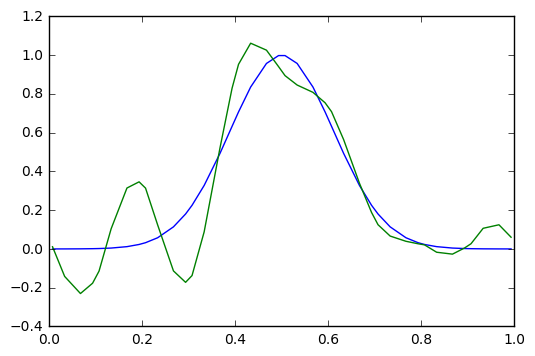

In [89]:
pyplot.plot(E.x, u_init(E.x))
pyplot.plot(E.x, u)